In [4]:
# 필요한 라이브러리 호출
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device("cuda:0")

In [3]:
torch.cuda.is_available()

True

In [5]:
# 데이터 전처리
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [16]:
# 데이터를 가져와서 훈련, 검증, 테스트 용도로 분리
img_directory = r'../DL_Data/CatDogtrain'

images_filepaths = sorted([os.path.join(img_directory, f) for f in os.listdir(img_directory)])    
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]    

random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:]

img3_directory = r'../DL_Data/MangoStar'
images3_filepaths = sorted([os.path.join(img3_directory, f) for f in os.listdir(img3_directory)])    
correct_images3_filepaths = [i for i in images3_filepaths if cv2.imread(i) is not None]    

random.shuffle(correct_images3_filepaths)
test_images_filepaths = correct_images3_filepaths[:]

print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 5000 10


In [19]:
# 커스텀 데이터셋 정리
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):        
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'CatDogtrain\dog':
            label = 1
        elif label == 'CatDogtrain\cat':
            label = 0

        return img_transformed, label

In [20]:
# 변수에 대한 값 정의
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [22]:
# 훈련, 검증, 테스트 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(test_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [23]:
# 데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1])


In [24]:
# AlexNet 모델 네트워크 정의
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [25]:
# 모델 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# 옵티마이저 및 손실 함수 정의
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [27]:
# 모델 네트워크 구조 확인
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [28]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
   
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [30]:
import time

In [31]:
# 모델 학습
num_epoch = 20
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/20
--------------------


C:\Users\SooHyun31\AppData\Local\Temp\ipykernel_2688\33347596.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6928 Acc: 0.5087


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.6919 Acc: 0.5174
Epoch 2/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6899 Acc: 0.5443


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.6856 Acc: 0.5120
Epoch 3/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6662 Acc: 0.6032


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.6377 Acc: 0.6438
Epoch 4/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6242 Acc: 0.6541


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.6133 Acc: 0.6672
Epoch 5/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.6029 Acc: 0.6752


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.5662 Acc: 0.7128
Epoch 6/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5820 Acc: 0.6996


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.5270 Acc: 0.7418
Epoch 7/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5632 Acc: 0.7144


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.5289 Acc: 0.7420
Epoch 8/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5383 Acc: 0.7354


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.5090 Acc: 0.7654
Epoch 9/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.5071 Acc: 0.7553


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.4519 Acc: 0.7882
Epoch 10/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.4651 Acc: 0.7829


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.4736 Acc: 0.7766
Epoch 11/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.4371 Acc: 0.7983


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.4285 Acc: 0.7978
Epoch 12/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.4055 Acc: 0.8166


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.3728 Acc: 0.8314
Epoch 13/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.3793 Acc: 0.8312


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.3212 Acc: 0.8552
Epoch 14/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.3498 Acc: 0.8465


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2933 Acc: 0.8700
Epoch 15/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.3247 Acc: 0.8615


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.4407 Acc: 0.8154
Epoch 16/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.3020 Acc: 0.8704


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2488 Acc: 0.8960
Epoch 17/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.2740 Acc: 0.8819


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2279 Acc: 0.9042
Epoch 18/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.2604 Acc: 0.8881


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2253 Acc: 0.9024
Epoch 19/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.2400 Acc: 0.8971


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2382 Acc: 0.9024
Epoch 20/20
--------------------


  0%|          | 0/625 [00:00<?, ?it/s]

train Loss: 0.2303 Acc: 0.9036


  0%|          | 0/157 [00:00<?, ?it/s]

val Loss: 0.2060 Acc: 0.9152
Training complete in 33m 34s


In [44]:
# 모델을 이용한 예측
import pandas as pd
id_list = []
pred_list = []
_id=0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id =test_path.split('/')[-1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        id_list.append(_id)
        pred_list.append(preds[0])
       
res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})
res.to_csv('../DL_Data/CDID', index=False)

C:\Users\SooHyun31\AppData\Local\Temp\ipykernel_2688\3562844698.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
# 데이터 프레임 결과 확인
res.head(10)

,id,label
0,MangoStar\8.jpg,0.296401
1,MangoStar\10.jfif,0.696302
2,MangoStar\6.jpg,0.995131
3,MangoStar\5.jpg,0.008325
4,MangoStar\4.jpg,0.089095
5,MangoStar\2.jpg,0.064058
6,MangoStar\3.jpg,0.981451
7,MangoStar\9.jpg,0.185840
8,MangoStar\1.jpg,0.041387
9,MangoStar\7.jpg,0.200931


In [46]:
# 예측 결과를 시각적으로 표현하기 위한 함수 정리
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        a = random.choice(res['id'].values)    
        label = res.loc[res['id'] == a, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

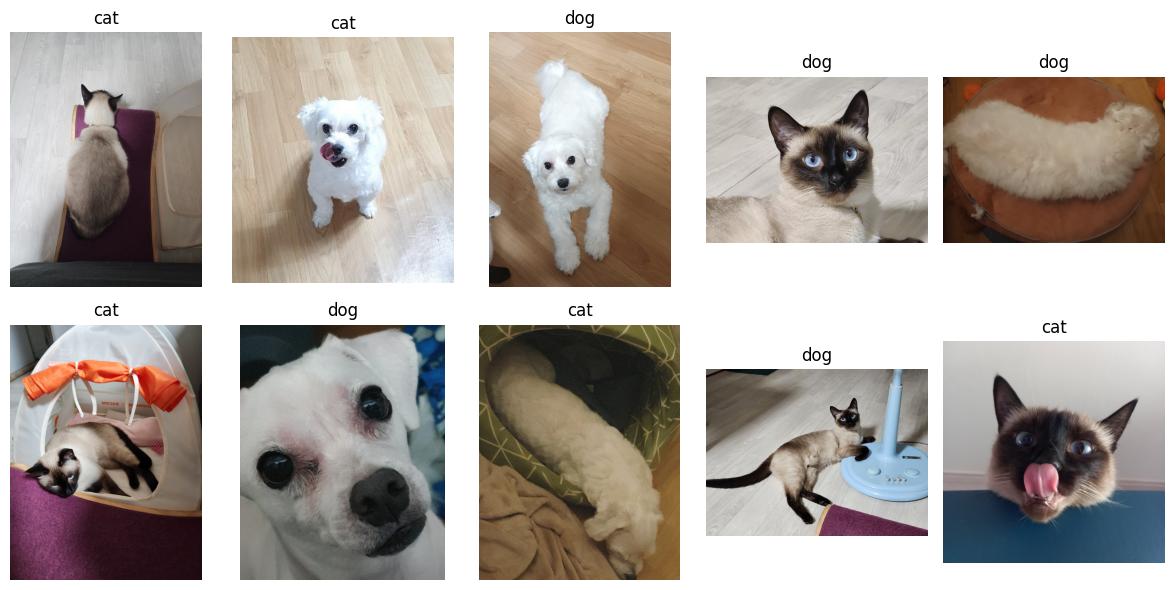

In [47]:
# 예측 결과에 대해 이미지와 함께 출력
display_image_grid(test_images_filepaths) 